# Convolutional Neural Nets

Here we'll use the PyTorch library to train a neural net based classifier on a higher-res version of the handwritten digit dataset

You can install what we need with `/usr/local/bin/pip3 install torch torchvision`

In [15]:
import torchvision
import numpy as np
import matplotlib.pyplot as plt

import torch
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


In [16]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5),(0.5))]) #convert from images to tensors

mnist_train = torchvision.datasets.MNIST( "./mnist", train=True, download=True, transform=transform )
mnist_test  = torchvision.datasets.MNIST( "./mnist", train=False, download=True, transform=transform )

Here we load the data.  The toTensor part is converting from a "PyImage" format to a "Tensor" which is basically just a numpy multi-dimensional array.

* The Normalize means we rescale the tensors so that the mean value is 0.5.
* Neural nets tend to be really sensitive to input scale/normalization issues.
  * If you're having trouble training a network, you might consider trying to normalize your data before using the network

In [17]:
# Note: For some reason the data is already broken into training and test data for us...

print( "Training data:" )
print( mnist_train.data.shape ) # 60,000 example imagers, 28x28  (x1...???)
print( mnist_train.targets.shape )

print( "\nTesting data:" )
print( mnist_test.data.shape )
print( mnist_test.targets.shape )

Training data:
torch.Size([60000, 28, 28])
torch.Size([60000])

Testing data:
torch.Size([10000, 28, 28])
torch.Size([10000])


We have 60k training images, 28x28 pixels, and 10k testing images

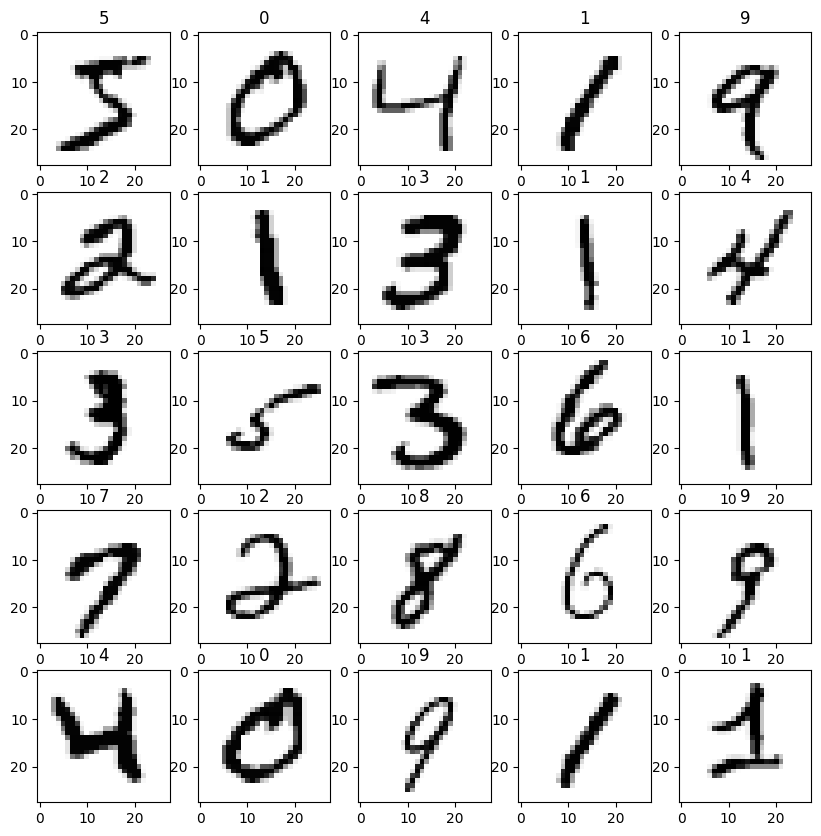

In [18]:
# Plot the first few images in the dataset...
plt.figure( figsize= (10, 10) )

for ii in np.arange( 25 ):
    plt.subplot( 5, 5, ii+1 )
    plt.imshow( mnist_train.data[ii, :, :], cmap='Greys',interpolation='none' )
    plt.title( int(mnist_train.targets[ii]) )

plt.show()

These are a lot higher res than the ones we were playing with in Scikit Learn

Here we define our neural net.  

This is using the PyTorch Model API, where we write the network out as a class with a constructor and a "forward" method.  The "forward" method describes the layers in the network and how they're used.  Based on what we do here, PyTorch will automatically compute the gradient for us, so we can train our weights.

Note: Took one of the image training example nets and modified/tweaked it...

We'll start with 2 convolution layers with max pooling in between and then 3 dense layers after that (I think this is probably overkill for this dataset, but it works well)

In [19]:

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        c1Out = 6 # convolution layer 1 will output 6 "images": one for each filter it trains
        c2Out = 16 # similarly for the 2nd convolution layer
        self.conv1 = nn.Conv2d( 1, c1Out, 3 ) # 1-D input, c1Out outputs, filter size 3x3 pixels
        
        # (28-2) x (28 -2) x c1Out outputs  # "-2" because 3x3 mask loses the 1st/last row/column
        
        self.pool = nn.MaxPool2d( 2, 2 ) # down sample 2x2 blocks to 1 value
        
        # 13*13*c1Out
        
        self.conv2 = nn.Conv2d( c1Out, c2Out, 3 ) # Inputs comes from conv1, specify our #outputs, use 3x3 blocks again
        
        # (13-2)*(13 -2)*c2Out
        # pool again
        # (11/2)*(11/2)*c2Out = 5x5 x c2Out
        
        #this is tricky.  The convolutions each shave 1 pixel off around the border, and then the
        #max pools reduce the number of pixels by 4
        self.pooledOutputSize = c2Out * 5 * 5 # 16 outputs per image whose size has been reduced
        self.fc1 = nn.Linear( self.pooledOutputSize, 120 )
        self.fc2 = nn.Linear( 120, 84 )
        self.fc3 = nn.Linear( 84, 10 ) # 10 outputs at the end

    ################################################################################
    # Take an image (or images) and run it through all stages of the net:
    #    
    def forward( self, x ): # "batch" of images
        # x is 4D tensor:  (batch size, width, height, #channels (1, grayscale image))
        # after conv1:  (batch size, width adjusted, height adjusted, conv1 # outputs)
        # after max pool: (batch size, width/2, height/2, conv1 # outputs)
        
        # print(x.shape) # During creation / debugging, getting the shape of layers correct is challenging... so display them.
        #x = F.relu(self.conv1(x))
        x = self.conv1(x)
        # print(x.shape)
        x = F.relu(x)
        # print(x.shape)
        x = self.pool(x)
        # print(x.shape)

        # Split into 2 lines above
        #x = self.pool(F.relu(self.conv1(x)))  #apply convolution filter, then run it through relu activation function
        x = self.pool(F.relu(self.conv2(x))) #ditto
        #print(x.shape) #uncomment to see the size of this layer.  It helped me figure out what pooledOutputSize shoudl be

        # Flatten: turn the 5x5xc2Out array into a single 1xN array.  The dense layers expect a 1D thing
        x = x.view(-1, self.num_flat_features(x))
        # x = x.view(x.shape[0], -1)  #equivalent ways of reshaping the data to be 1D
        # x = x.view(batch_size( x.shape[0]) , -1)
        x = F.relu(self.fc1(x)) #apply dense layer 1
        x = F.relu(self.fc2(x)) #and dense layer 2, using ReLU activation
        x = self.fc3(x) #final dense layer.  No activation function on this
        return x
    
    #compute the output size after our convolution layers
    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features


net = Net()


In [20]:
def train( model, epochs ): # One epoch uses the entire training set (one batch at a time) - 60,000 images in this case
    
    criterion = nn.CrossEntropyLoss() # this is a way of measuring error (loss) for classification that takes the
                                      # "confidence" of a prediction into account.  High confidence, correct predictions are low cost, 
                                      # high confidence, wrong predictions are high cost, medium confidence predictions have cost

    # use the ADAM optimizer to find the best weights
    optimizer = optim.Adam( model.parameters(), lr= 1e-4 ) 
    
    #this loads data and gets it in the right format for us
    trainloader = torch.utils.data.DataLoader( mnist_train, batch_size=8,
                                               shuffle=True, num_workers=0 )

    for epoch in range( epochs ): # loop over the dataset multiple times

        running_loss = 0.0
        for i, data in enumerate( trainloader, 0 ):
            # get the inputs; data is a list of [inputs, labels]

            inputs, labels = data
            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs) #predict the output with some training data
            loss = criterion(outputs, labels) #see how well we did

            loss.backward() #see how to change the weights to do better
            optimizer.step() #and actually change the weights

            # print statistics
            running_loss += loss.item()
            if i % 2000 == 1999:    # print every 2000 mini-batches
                print('[%d, %5d] loss: %.3f' %
                      (epoch + 1, i + 1, running_loss / 2000))
                running_loss = 0.0

    print('Finished Training')

def evaluate( model ):  
    #load some test data
    testloader = torch.utils.data.DataLoader( mnist_test, batch_size=8,
                                              shuffle=True, num_workers=0 )
    correct = 0
    total = 0

    with torch.no_grad(): # <- Since we are not training, the model does not need to calculate gradients
        for data in testloader:
            images, labels = data
            outputs = model( images )
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    # Just do a coarse evaluation... how many did we predict correcly?
    print( 'Accuracy of the network on the 10000 test images: %d %%' % ( 100 * correct / total) )
    

In [21]:
# Note: On my home (older PC), this takes 3-ish minutes to run...
print( "Training..." )
train( net, 4 )

print( "Evaluating..." )
evaluate( net )

Training...
[1,  2000] loss: 0.932
[1,  4000] loss: 0.331
[1,  6000] loss: 0.244
[2,  2000] loss: 0.160
[2,  4000] loss: 0.149
[2,  6000] loss: 0.130
[3,  2000] loss: 0.105
[3,  4000] loss: 0.095
[3,  6000] loss: 0.086
[4,  2000] loss: 0.078
[4,  4000] loss: 0.075
[4,  6000] loss: 0.066
Finished Training
Evaluating...
Accuracy of the network on the 10000 test images: 97 %


In [8]:
# Try a different network.  Use more convolution layers and fewer dense layers, so fewer weights overall
class Net2(nn.Module):
    def __init__(self):
        super(Net2, self).__init__()
        c1Out = 4
        c2Out = 8
        c3Out = 16
        self.conv1 = nn.Conv2d(1, c1Out, 3) #1-D input, 5 outputs, filter size 3x3 pixels
        self.pool = nn.MaxPool2d(2, 2) #downsample 2x2 blocks to 1 value
        self.conv2 = nn.Conv2d(c1Out, c2Out, 3) #5 inputs (# outputs from conv 1), 5 outputs, 3x3 blocks
        self.conv3 = nn.Conv2d(c2Out, c3Out, 3)
        self.pooledOutputSize = c3Out*1*1 # 16 outputs per image whose size has been reduced
        self.fc1 = nn.Linear(self.pooledOutputSize, 32)
        self.fc2 = nn.Linear(32, 10)
        #self.fc3 = nn.Linear(32, 10)


    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        #print(x.shape)
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        #x = F.relu(self.fc2(x))
        x = self.fc2(x)
        return x
    
    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features


net2 = Net2()


In [9]:
print( "Training Net Version 2..." )
train( net2, 8 )

print( "Evaluating..." )
evaluate( net2 )

Training Net Version 2...
[1,  2000] loss: 2.093
[1,  4000] loss: 1.122
[1,  6000] loss: 0.833
[2,  2000] loss: 0.609
[2,  4000] loss: 0.539
[2,  6000] loss: 0.476
[3,  2000] loss: 0.415
[3,  4000] loss: 0.376
[3,  6000] loss: 0.342
[4,  2000] loss: 0.316
[4,  4000] loss: 0.303
[4,  6000] loss: 0.283
[5,  2000] loss: 0.268
[5,  4000] loss: 0.271
[5,  6000] loss: 0.248
[6,  2000] loss: 0.242
[6,  4000] loss: 0.235
[6,  6000] loss: 0.216
[7,  2000] loss: 0.217
[7,  4000] loss: 0.207
[7,  6000] loss: 0.216
[8,  2000] loss: 0.211
[8,  4000] loss: 0.201
[8,  6000] loss: 0.187
Finished Training
Evaluating...
Accuracy of the network on the 10000 test images: 94 %


In [10]:
conv1Weights = net2.conv1.weight.detach().numpy()

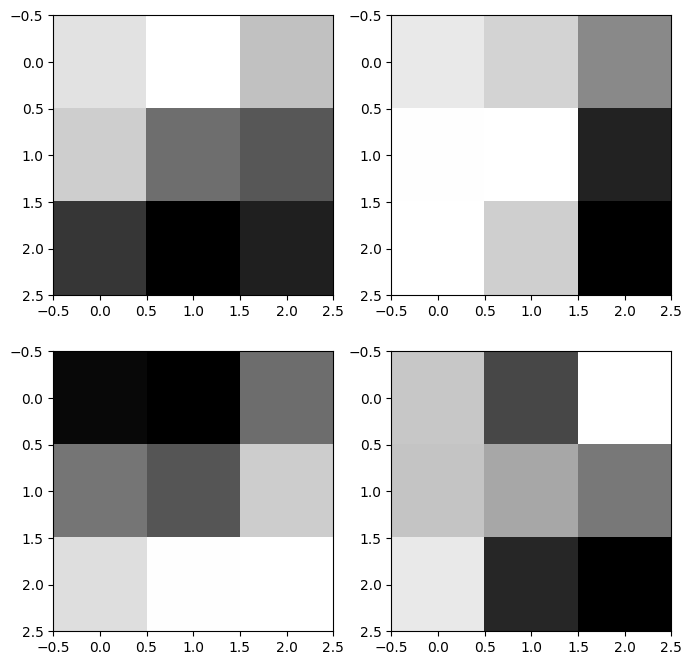

In [11]:
fig = plt.figure(figsize=(8, 8))
for i in range(conv1Weights.shape[0]): #for each filter we trained
    fig.add_subplot(2,2,i + 1)
    plt.imshow(conv1Weights[i,:,:,:].reshape(3,3), cmap='Greys',interpolation='none')

(8, 4, 3, 3)


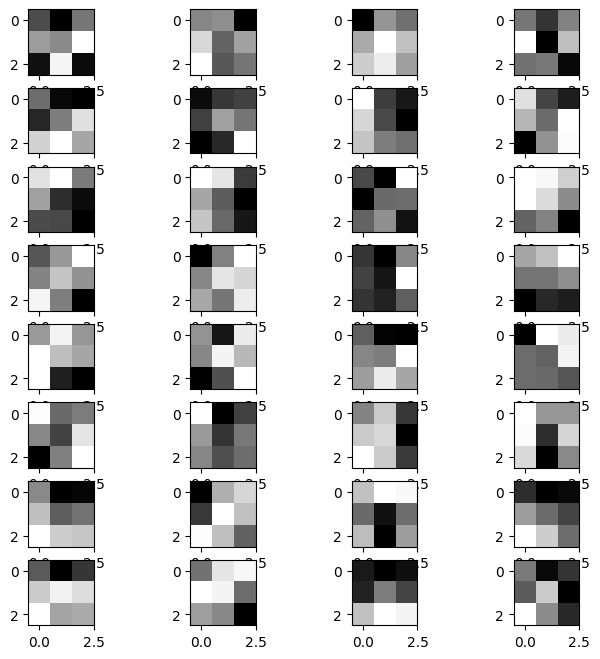

In [12]:
conv2Weights = net2.conv2.weight.detach().numpy()
print(conv2Weights.shape)
fig = plt.figure(figsize=(8, 8))
for i in range(conv2Weights.shape[0]): #for each filter we trained
    for j in range(conv2Weights.shape[1]): #since there were many input channels, theres more
        fig.add_subplot(8,4,i*4 + j + 1)
        plt.imshow(conv2Weights[i,j,:,:].reshape(3,3), cmap='Greys',interpolation='none')